
# How Elon Musk's tweets affect stock prices?


# Application setup

First of all, let's setup authentication to Twitter API.


In [38]:

import numpy
import tweepy
import pandas
import SECRETS
import re
import matplotlib.pyplot as plt

# Authenticate to Twitter
auth = tweepy.OAuthHandler(SECRETS.API_KEY, SECRETS.API_SECRET_KEY)
auth.set_access_token(SECRETS.ACCESS_TOKEN, SECRETS.ACCESS_SECRET_TOKEN)

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print('Authentication OK')
except:
    print('Error during authentication')


Authentication OK



Everything seems fine, we can proceed to download data.

5 latest tweets:


In [39]:

musk_tweets = api.user_timeline(screen_name='elonmusk',
                                count=5,
                                tweet_mode='extended'
                                )

for tweet in musk_tweets:
     print('------------')
     print("ID: {}".format(tweet.id))
     print(tweet.created_at)
     print(tweet.full_text)


------------
ID: 1396280083589976064
2021-05-23 01:41:28
@SpaceNews_Inc Congrats! @virgingalactic
------------
ID: 1396230120692543489
2021-05-22 22:22:56
https://t.co/7afq6DIlzc
------------
ID: 1396226161718349824
2021-05-22 22:07:12
@flcnhvy @thatdogegirl @WhatsupFranks @TeslaGong Becoming multiplanetary is one of the greatest filters. Only now, 4.5 billion years after Earth formed, is it possible. 

How long this window to reach Mars remains open is uncertain. Perhaps a long time, perhaps not. 

In case it is the latter, we should act now.
------------
ID: 1396049958000685060
2021-05-22 10:27:01
@PPathole @SpaceX The hard part about Raptor is simplifying it
------------
ID: 1396049547680391168
2021-05-22 10:25:24
@TheRealShifo The true battle is between fiat &amp; crypto. On balance, I support the latter.



# Downloading tweets

We will download at least 5000 tweets to have reasonable data set.
It is worth mentioning here that the maximum allowed .user_timeline(count=) is 200.


In [40]:

downloaded_tweets = []
last_id = musk_tweets[-1].id

while len(downloaded_tweets)<5000:
    musk_tweets = api.user_timeline(screen_name='elonmusk',
                               count=200,
                               include_rts = False,
                               max_id = last_id - 1,
                               tweet_mode = 'extended'
                               )
    downloaded_tweets.extend(musk_tweets)
    # if len(musk_tweets) == 0:
    #     break
    if len(musk_tweets) != 0:
        last_id = musk_tweets[-1].id
        downloaded_tweets.extend(musk_tweets)
    print('N of tweets downloaded till now {}'.format(len(downloaded_tweets)))

print(len(downloaded_tweets))


N of tweets downloaded till now 70
N of tweets downloaded till now 70
N of tweets downloaded till now 432
N of tweets downloaded till now 432
N of tweets downloaded till now 432
N of tweets downloaded till now 432
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 820
N of tweets downloaded till now 1204
N of tweets downloaded till now 1588
N of tweets downloaded till now 1588
N of tweets downloaded till now 1588
N of tweets downloaded till now 1588
N of tweets downloaded till now 1962
N of tweets downloaded till now 1962
N of tweets downloaded 


# Reviewing data


In [41]:

words_in_tweets = {}

for tweet in downloaded_tweets:

    # using regular expression to be exclude all "@#!.?"
    t_words = re.findall(r'\w+', tweet.full_text)

    # adding words counting
    for word in t_words:
        if word in words_in_tweets:
            words_in_tweets[word] += 1
        else:
            words_in_tweets[word] = 1

words_to_work_with = words_in_tweets.copy()



We have dictionary {'word' : times_used}


Let's plot some words


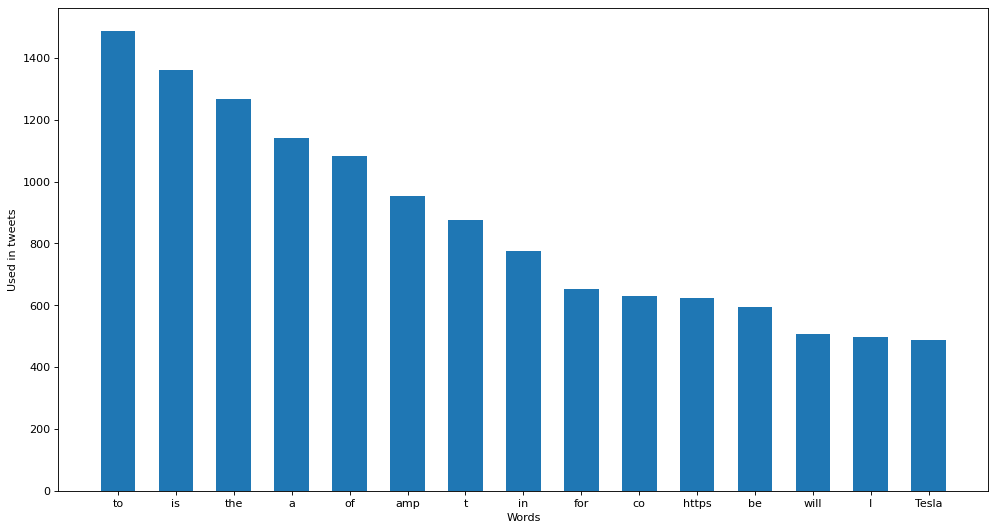

In [42]:

# we don't want to print all words yet, so let's have a look at 30 of them first
df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()



# Improving data quality

 We need to improve quality of our data. Let's delete some unimportant words like "the" "a" "is" etc,
 then print once again

- It is also a good idea to save words_in_tweets to pandas.dataFrame.
- We need to use the field *.created_at* in every tweet we are interested in (*downloaded_tweets*).


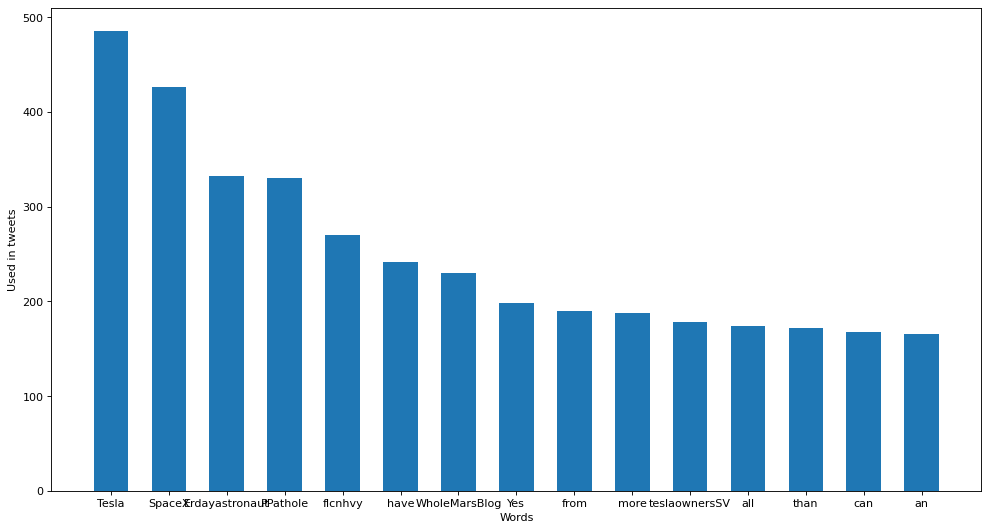

In [43]:

unimportant_words = ['the' ,'a', 'to', 'is', 't', 'of',
                     'be', 'will', 'that', 'this', 'https',
                     'co', 'on', 'we', 'with', 'so', 'for',
                     'at', 'but', 's', 'you', 'was', 'in',
                     'it', 'I', 'or', 'year', 'as', 'are',
                     'no', 'not', 'with', 'This', 'It', 'much',
                     'We', 'do', 'by', 'just', 'The', 'amp'
                     ]
for word in unimportant_words:
    words_to_work_with.pop(word, None)

df = pandas.DataFrame(words_to_work_with.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()


In [44]:

# saving our dictionary to DataFrame
words_in_tweets_df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])

print(words_in_tweets_df.head(15))

# saving downloaded_tweets into a pandas.DataFrame
# firstly, we need to create list  which will help us putting interesting data in df

temp_list_of_dicts = []
for tweet in downloaded_tweets:
    temp_list_of_dicts.append({'id': tweet.id,
                               'text': tweet.full_text,
                               'date': tweet.created_at})

# FILTERING DATA
downloaded_tweets_df = pandas.DataFrame(temp_list_of_dicts)
downloaded_tweets_df['text'] = downloaded_tweets_df['text'].str.lower()

df_tesla_word = downloaded_tweets_df[downloaded_tweets_df['text'].str.contains('tesla', na=False)]

# we have tweets with words tesla or spacex
print(df_tesla_word.shape)


                 word  used
0                 Any     6
1        sufficiently     2
2            advanced    22
3               magic     6
4                  is  1360
5   indistinguishable     4
6                from   190
7          technology    26
8       RocketRundown     2
9             Welcome     4
10                 to  1488
11                the  1266
12             future    56
13                 It   214
14                  s   390
(904, 3)



# Downloading historical data of tesla stock prices

Let's check the oldest tweet and download stock data from this day.


In [45]:

# extracting date to string
oldest_tweet_about_tesla_date = str(df_tesla_word.date.iloc[-1])

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split(' ')

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date[0]

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split('-')

# YEAR MONTH DAY
date_tesla = [int(a) for a in oldest_tweet_about_tesla_date]


In [46]:
# importing important libraries
from datetime import datetime
import yfinance as yahoofinance


In [47]:

# downloading dataframe from Yahoo Finance
start_date = datetime(date_tesla[0], date_tesla[1], date_tesla[2])
end_date = datetime.now()
tesla_stock_prices_data = yahoofinance.download('TSLA', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed



# Adjusting and merging Dataframes


In [48]:

temp_DF = df_tesla_word.copy()
temp_DF.reset_index(inplace=True)
tweets_dates_list = []

temp_DF = temp_DF.drop(columns=['index', 'id', 'text'])
for row in temp_DF.date:
    tweets_dates_list.append(str(row).split(' ')[0])

# adjusting dataframe and cleaning data
tweets_dates_DF = pandas.DataFrame(data=tweets_dates_list)
tweets_dates_DF.drop_duplicates(inplace=True)
tweets_dates_DF =  tweets_dates_DF[::-1]
tweets_dates_DF.reset_index(inplace=True)
tweets_dates_DF = tweets_dates_DF.drop(columns=['index'])
tweets_dates_DF.columns = ['Date']

prices_data = tesla_stock_prices_data.copy()
prices_data.reset_index(inplace=True)
# changing TimeStamp to str (because tweets_dates_DF.Date is str)
prices_data['Date']= prices_data['Date'].astype(str)

# merging data to print relevant markers in specific dates, dropping useless columns
inner_merged = pandas.merge(tweets_dates_DF, prices_data)
inner_merged = inner_merged.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])
prices_data = prices_data.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])

print(inner_merged.head())
print(prices_data.head())


         Date        High
0  2020-07-06  275.558014
1  2020-07-07  285.899994
2  2020-07-08  283.451996
3  2020-07-09  281.712006
4  2020-07-10  309.783997
         Date        High
0  2020-07-06  275.558014
1  2020-07-07  285.899994
2  2020-07-08  283.451996
3  2020-07-09  281.712006
4  2020-07-10  309.783997



# Plotting stock prices with tweet days markers


<ipython-input-49-0e784a0f3b6c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  stock_price.set_xticklabels(prices_data.Date)
<ipython-input-49-0e784a0f3b6c>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  musk_twitter_act = stock_fig.add_subplot(111)


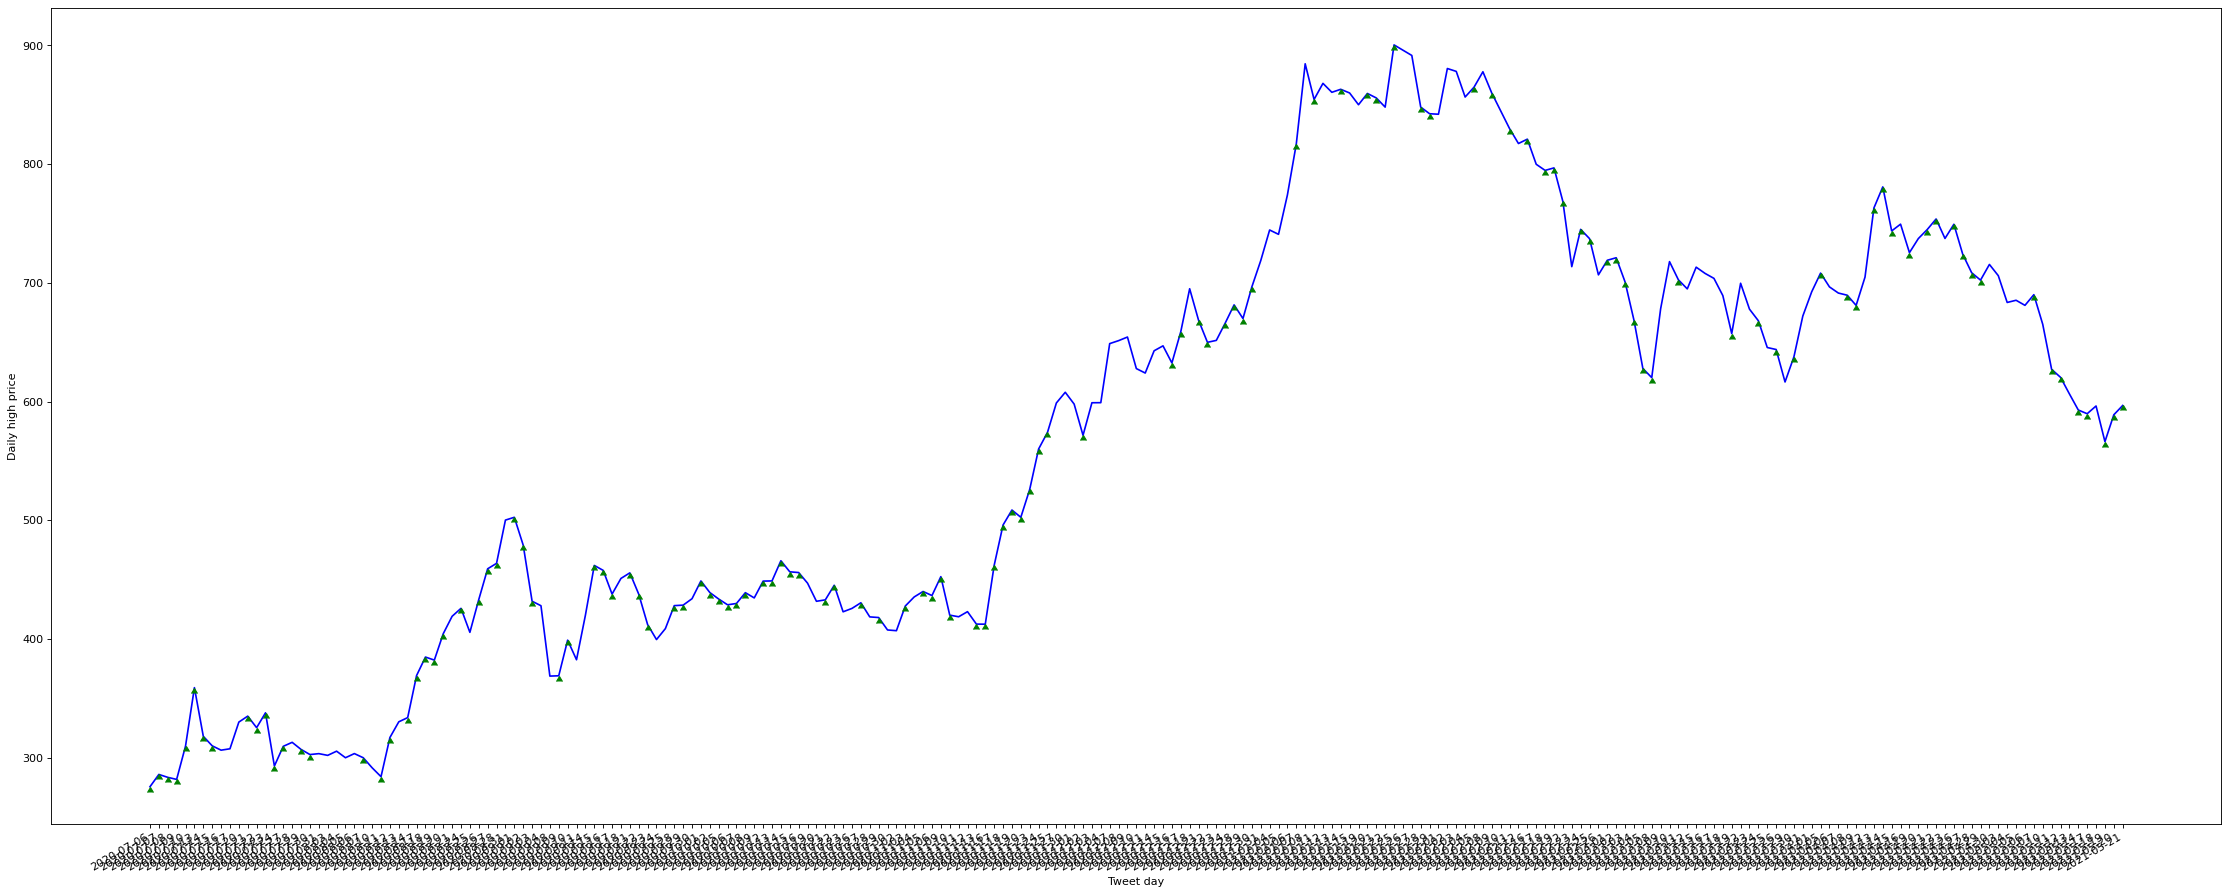

In [49]:

stock_fig = plt.figure(figsize=(35, 15), dpi=80)


stock_price = stock_fig.add_subplot(111)
stock_price.set_xticklabels(prices_data.Date)
stock_price.xaxis_date()
stock_price.plot(prices_data.Date,
                 prices_data.High,
                 color='b'
                 )
stock_price.set_ylabel('Daily high price')
stock_price.set_xlabel('Date')

musk_twitter_act = stock_fig.add_subplot(111)
musk_twitter_act.xaxis_date()
musk_twitter_act.plot(inner_merged.Date, inner_merged.High,
                      marker=6, color='g', linestyle = 'None'
                      )
musk_twitter_act.set_xlabel('Tweet day')

stock_fig.autofmt_xdate()
plt.show()



# First analysis

At this point we can draw some conclusions, but firstly - let's think about the correlation between the tweet and the
stock price. To explore this we can check some of financial indicators used in technical analysis like moving average.


In [50]:

# dataframe setup for difference and moving average
prices_data['Difference'] = prices_data.High.diff()
inner_merged.drop('High', inplace=True, axis=1)

# marking tweet day
inner_merged['tweet_day'] = 'tweet'


         Date        High  Difference
0  2020-07-06  275.558014         NaN
1  2020-07-07  285.899994   10.341980
2  2020-07-08  283.451996   -2.447998
3  2020-07-09  281.712006   -1.739990
4  2020-07-10  309.783997   28.071991
         Date tweet_day
0  2020-07-06     tweet
1  2020-07-07     tweet
2  2020-07-08     tweet
3  2020-07-09     tweet
4  2020-07-10     tweet
          Date        High  Difference tweet_day  MovingAverage_10
0   2020-07-06  275.558014         NaN     tweet               NaN
1   2020-07-07  285.899994   10.341980     tweet               NaN
2   2020-07-08  283.451996   -2.447998     tweet               NaN
3   2020-07-09  281.712006   -1.739990     tweet               NaN
4   2020-07-10  309.783997   28.071991     tweet               NaN
5   2020-07-13  358.997986   49.213989     tweet               NaN
6   2020-07-14  318.000000  -40.997986     tweet               NaN
7   2020-07-15  310.000000   -8.000000     tweet               NaN
8   2020-07-16  306.34201

In [54]:
# merging dataframes to illustrate differences at the tweet days
difference_compared = pandas.merge(prices_data, inner_merged, on='Date', how='outer')
difference_compared['MovingAverage_4'] = difference_compared.iloc[:,1].rolling(window=4).mean()

print(difference_compared.head(30))




          Date        High  Difference tweet_day  MovingAverage_4
0   2020-07-06  275.558014         NaN     tweet              NaN
1   2020-07-07  285.899994   10.341980     tweet              NaN
2   2020-07-08  283.451996   -2.447998     tweet              NaN
3   2020-07-09  281.712006   -1.739990     tweet       281.655502
4   2020-07-10  309.783997   28.071991     tweet       290.211998
5   2020-07-13  358.997986   49.213989     tweet       308.486496
6   2020-07-14  318.000000  -40.997986     tweet       317.123497
7   2020-07-15  310.000000   -8.000000     tweet       324.195496
8   2020-07-16  306.342010   -3.657990       NaN       323.334999
9   2020-07-17  307.502014    1.160004       NaN       310.461006
10  2020-07-20  330.000000   22.497986       NaN       313.461006
11  2020-07-21  335.000000    5.000000     tweet       319.711006
12  2020-07-22  325.283997   -9.716003     tweet       324.446503
13  2020-07-23  337.799988   12.515991     tweet       332.020996
14  2020-0


# Summarization

The graph displays the stock price of Tesla as a function of time.
The days when Elon tweeted were marked with dots.
There is an equal number of dots preceding an ascending, as there are a descending slope.
Therefore, we cannot draw the conclusion that Elon's tweets influence the stock prices.

